# LOG6308 : Tp1 - Recommendation by collaboratif filtering 

- Clément Bernard (2096223)
- Ghaith Dekhili ()

## Importations 

In [505]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import time
from sklearn.cluster import KMeans

## Data 

In [443]:
# The path where is the fold data
PATH_DATA = 'data'

In [444]:
# The items 
items = pd.read_csv(os.path.join(PATH_DATA, 'items.csv'), sep='|')
# User data 
u = pd.read_csv(os.path.join(PATH_DATA, 'u.csv'), sep='|')
# Votes of the user 
votes = pd.read_csv(os.path.join(PATH_DATA, 'votes.csv'), sep='|')

In [445]:
items

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [446]:
u

,id,age,gender,job,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [447]:
votes

,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


## Creation of sparse matrix : User-item matrix

In [448]:
# The number of users 
N_USERS = u.shape[0]
# The number of items 
N_ITEMS = items.shape[0]

In [449]:
def create_sparse_matrix(votes) : 
    ''' Create a User-Items sparse matrix '''
    # Create NaN for each items and users 
    data = {i : [np.nan for j in range(N_USERS + 1)] for i in range(N_ITEMS+1)}
    def to_convert(x, data) :
        data[x['item.id']][x['user.id']] = x['rating']
        return None 
    votes.apply(to_convert , axis = 1 , args = [data])
    return pd.DataFrame(data)

In [450]:
user_item = create_sparse_matrix(votes)

In [451]:
user_item

,0,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question 1 

- Tout d'abord, nous creons les indexes qui vont permettre de diviser nos données pour la cross-validation

In [452]:
def kfold(n_data, k = 10 , SEED = 77, shuffle = False ) : 
    ''' Split the data into K-Folds 
        Input : The length of the data to split 
        Output : The indexes of the different folds 
    '''
    # Fix the SEED to have consistent results 
    np.random.seed(SEED)
    # Create the indexes 
    indexes = np.arange(n_data)
    # Shuffle the matrix 
    if shuffle : 
        np.random.shuffle(indexes)
    # The size of the subindexes
    sub_size = n_data // k 
    # Size of the last fold used for the test 
    last_size = sub_size + n_data%k
    # Where we store all the indexes 
    all_indexes = {'train' : [], 'test' : []}
    # Index of the test 
    test_i = 0 
    for i in range(k) :
        train = []
        # Check if we are the last set 
        if test_i == k-1 : 
            all_indexes['test'].append(indexes[-last_size:])
            all_indexes['train'].append(indexes[:-last_size ])
        else : 
            all_indexes['test'].append(indexes[ test_i * sub_size : (test_i+1) * sub_size ])
            # Get the indexes outside the test indexes
            train = [] 
            train.extend(indexes[:test_i * sub_size])
            train.extend(indexes[(test_i+1) * sub_size : ])
            all_indexes['train'].append(train)
        
        
        test_i +=1 
        
    return all_indexes


- Maintenant, nous implémentons les fonctions pour calculer les valeurs moyennes des utilisateurs et items 

In [313]:
def average_user(user_item) : 
    ''' Compute the average score for the users '''
    # Compute the mean for the users 
    return user_item.apply( lambda x : np.mean(x) , axis = 1 ).iloc[1:]
    
def average_item(user_item) : 
    ''' Compute the average score for the items '''
    # Compute the mean for the items 
    return user_item.apply( lambda x : np.mean(x) , axis = 0 ).iloc[1:]

- Utilisation de la cross-validation pour calculer l'erreur 

In [356]:
def cross_validation(N ,k , votes = votes , user_item = user_item) : 
    ''' Compute the quadratic error with K-cross-validation
        Inputs : 
            - N : The size of the data to split (either size of items or users)
    '''
    # Dictionnary that will store the errors 
    errors = {}
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = False ).values())) : 
        # Copy the original user-item matrix 
        u_item = user_item.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:2]
        
        def to_convert(x, user_item) :
            # Make the test rating to NaN
            user_item[x['item.id']][x['user.id']] = np.nan
        # Convert the test rating to NaN
        indexes_test.apply(to_convert , axis = 1 , args = [u_item])
        # Get the mean within the training indexes
        mean_item = average_item(u_item).fillna(0)
        mean_user = average_user(u_item).fillna(0)

        errors[i] = 0 
        
        def compute_dist(x, mean_item, mean_user, user_item, errors, i) :
            '''Compute the RMSE''' 
            # Get the item id 
            item = x['item.id']
            # Get the user id 
            user = x['user.id']
            
            # Make the prediction : the mean between user and item score 
            prediction = (mean_item[item] + mean_user[user])/2
            # Get the true label 
            true_value = user_item.iloc[user,item]
            # Compute the error 
            error =  ( prediction - true_value)**2
            # If NaN : pass
            if np.isnan(error) :
#                 print(mean_item[item], mean_user[user])
#                 print(item, user, prediction, true_value)
                return None
            # Increment the error 
            errors[i]+=error
            return None 
        # Apply the computation of RMSE 
        indexes_test.apply(compute_dist, axis = 1 , args = [mean_item, mean_user, user_item, errors,i])
        # Normalise by the size of the testing set 
        errors[i]/=indexes_test.shape[0]
        errors[i] = np.sqrt(errors[i])
            
    return errors
    

In [357]:
# votes[votes['user.id'] == 734][votes['item.id'] == 419]

In [358]:
# average_item(user_item).iloc[1566]

In [359]:
error_user = cross_validation( N = votes.shape[0] ,k = 10  )

In [360]:
error_user

{0: 0.9902061177690663,
 1: 1.0028416663200765,
 2: 0.9821542411338631,
 3: 0.9877557371326886,
 4: 0.9768220401686872,
 5: 0.9732845859194262,
 6: 0.9710911211326629,
 7: 0.9774403962893048,
 8: 0.9722847572291874,
 9: 0.9858413549208976}

<BarContainer object of 10 artists>

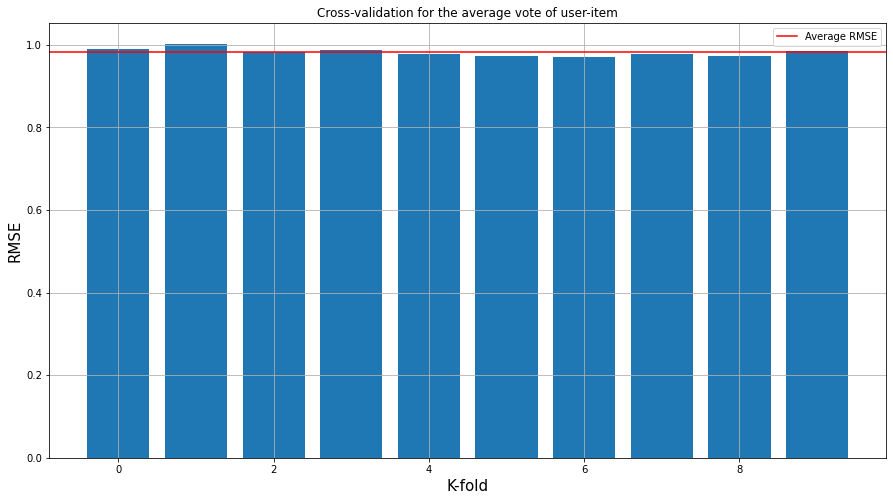

In [361]:
plt.figure(figsize=(15,8))
plt.title('Cross-validation for the average vote of user-item')
plt.xlabel('K-fold',fontsize=15)
plt.axhline(y = np.mean(list(error_user.values())), color = 'r', linestyle = '-', label='Average RMSE') 
plt.ylabel('RMSE',fontsize=15)
plt.grid(True)
plt.legend()
plt.bar(list(error_user.keys()) , list(error_user.values()))

- Print the results 

In [362]:
# ON DOIT OBTENIR 0.93
print('Average Mean square error for all the folds : {}'.format(np.mean(list(error_user.values()))))

Average Mean square error for all the folds : 0.981972201801586


## Question 2 

In [363]:
user_item = user_item.iloc[1:,1:]

## 2.a

In [364]:
item_item = user_item.T.copy()

In [365]:
item_item

,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [490]:
def get_similarity_matrix(item_item, size = N_ITEMS) : 
    ''' Return a dataframe of size : N_ITEM x N_ITEM with the similarity for each user 
            within the other items '''
    
    df_sim = pd.DataFrame(np.zeros((size, size)))
    for a in range(N_ITEMS) :
        df_sim.iloc[a] = cosine_similarity(item_item.iloc[a].fillna(0).values.reshape(1, -1), item_item.fillna(0))
    return df_sim

In [30]:
initial_time = time.time()
def_sim = get_similarity_matrix(item_item)
print(time.time()-initial_time)

29.304980993270874


In [34]:
def_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


In [35]:
def_sim.shape

(1682, 1682)

# Affichage de la distribution de la similarité

Text(0, 0.5, 'Number of values')

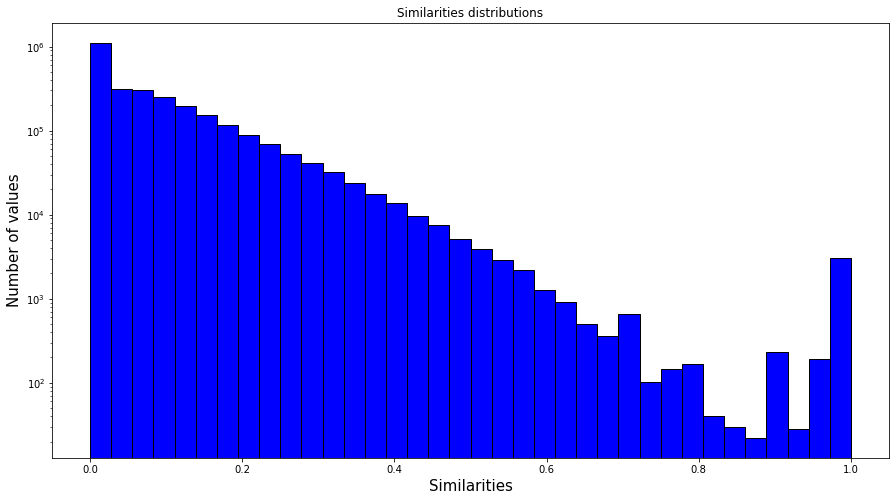

In [38]:
plt.figure(figsize=(15,8))
testList__ = def_sim.values.flatten()
plt.hist(testList__, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)
# Add labels
plt.title('Similarities distributions')
plt.xlabel('Similarities',fontsize=15)
plt.ylabel('Number of values',fontsize=15)

In [39]:
def print_zeros_weighs_proportion(df):
    """
    prints proportion of zeros among all similarities values
    """
    numZeros = (df == 0 ).sum().sum()
    print("proportion of zero weights = ", numZeros/df.size)
    

In [40]:
print_zeros_weighs_proportion(def_sim)

proportion of zero weights =  0.3043450905651361


### 2.b 

In [46]:
def buil_neighbors_indexes(item_item):
    """
    Returns a df with items and their neighbors with similarities and a df with neighbors' indexes 
    """
    #A df for items and their neighbors with similarities
    df_10_neighbors = pd.DataFrame(np.zeros((N_ITEMS, 10)), index = range(1,N_ITEMS+1))  
    #A df for items with their neighbors' indexes 
    df_10_index = pd.DataFrame(np.zeros((N_ITEMS, 10)), index = range(1,N_ITEMS+1))
                                
    #count = 0
    for i in range(len(item_item)):
        mySeries = def_sim.iloc[i].copy()    
        for n in range(10):
            max_val = mySeries.values.max()
            max_idx = pd.Index(mySeries).get_loc(max_val)
            
            #we don't take the actual item as neighbor of itself
            if type(max_idx) is int and max_idx == i:
                mySeries = mySeries.drop(mySeries.index[max_idx])
                max_val = mySeries.values.max()
                max_idx = pd.Index(mySeries).get_loc(max_val)
            
            #There are some max with a list of boolean as index, so we don't take them
            while type(max_idx) is not int:
                #count +=1
                mySeries = mySeries.drop(mySeries.index[max_idx])
                max_val = mySeries.values.max()
                max_idx = pd.Index(mySeries).get_loc(max_val)            
            
            df_10_neighbors.iloc[i,n] =  max_val
            #in the next line we add 1 as our items index start with 1  
            df_10_index.iloc[i,n] = int(max_idx+1)
            mySeries = mySeries.drop(mySeries.index[max_idx])
            #print("count:",count)
    return df_10_neighbors, df_10_index

In [42]:
df_10_neighbors_sim,df_10_index = buil_neighbors_indexes(item_item)

In [43]:
df_10_neighbors_sim.head()

,0,1,2,3,4,5,6,7,8,9
1,0.734572,0.699925,0.689786,0.664555,0.641322,0.638158,0.636727,0.630601,0.624075,0.622382
2,0.659619,0.623544,0.617274,0.616143,0.604969,0.601960,0.597083,0.595684,0.590124,0.584100
3,0.452023,0.444355,0.423249,0.404930,0.404787,0.404239,0.404080,0.401676,0.397274,0.396868
4,0.650507,0.628946,0.628720,0.620055,0.617312,0.604652,0.602747,0.601488,0.601319,0.599989
5,0.547787,0.472725,0.472399,0.450780,0.445242,0.440996,0.435349,0.430292,0.425298,0.424652


In [44]:
df_10_neighbors_sim.shape

(1682, 10)

In [45]:
df_10_index.head()

,0,1,2,3,4,5,6,7,8,9
1,49.0,179.0,119.0,115.0,400.0,147.0,216.0,98.0,229.0,168.0
2,232.0,160.0,382.0,399.0,61.0,570.0,223.0,227.0,542.0,94.0
3,409.0,761.0,41.0,32.0,247.0,16.0,1040.0,818.0,469.0,231.0
4,55.0,202.0,172.0,199.0,94.0,191.0,169.0,208.0,77.0,375.0
5,217.0,217.0,53.0,230.0,52.0,95.0,665.0,196.0,657.0,551.0


##### Distribution du nombre de voisins avec votes communs par item

In [47]:
neigh_with_com_votes = (def_sim != 0).sum(axis=1)
#neigh_with_com_votes = (def_sim > 0).count(axis=1)
print(neigh_with_com_votes)

0       1594
1       1554
2       1413
3       1588
4       1525
        ... 
1677     107
1678     107
1679     107
1680     362
1681     317
Length: 1682, dtype: int64


Text(0, 0.5, 'y')

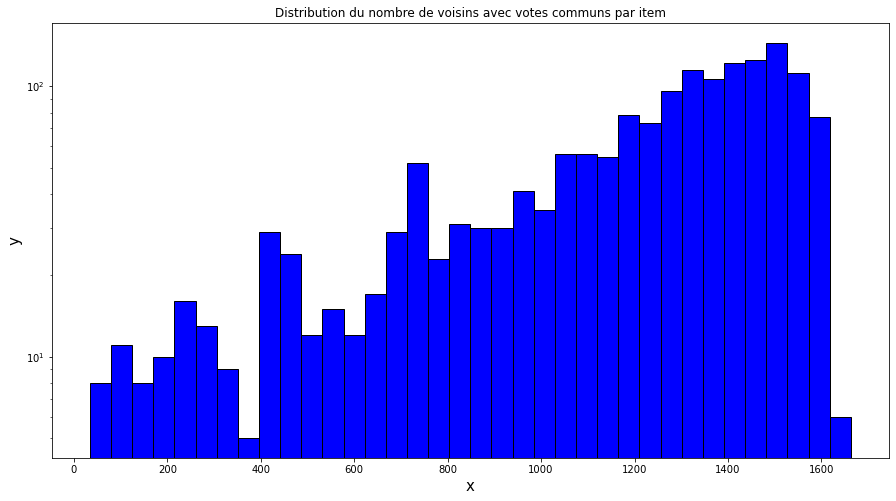

In [49]:
# !!!!!!!!!!!! le diagramme n'est pas bon 
plt.figure(figsize=(15,8))
plt.hist(neigh_with_com_votes, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)
# Add labels
plt.title('Distribution du nombre de voisins avec votes communs par item')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)

##### Proportion de votes manquants

In [50]:
user_item.isna().sum(axis = 0)

1       491
2       812
3       853
4       734
5       857
       ... 
1678    942
1679    942
1680    942
1681    942
1682    942
Length: 1682, dtype: int64

Text(0, 0.5, '#items')

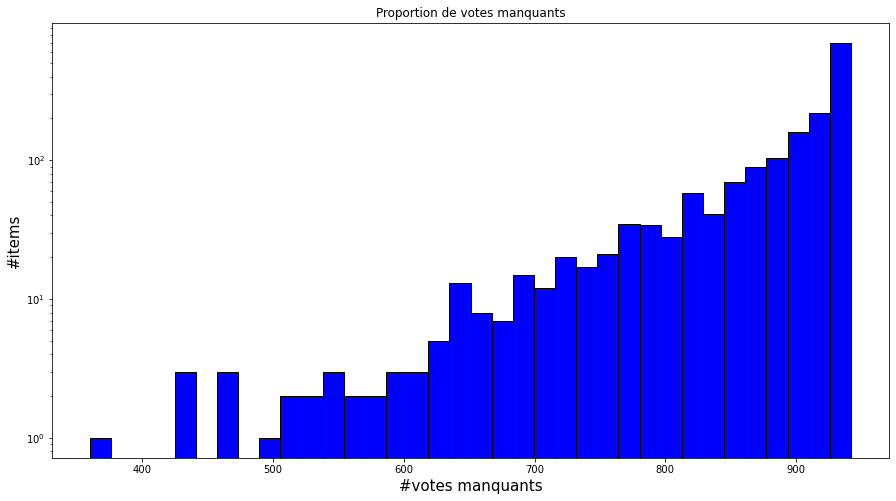

In [53]:
plt.figure(figsize=(15,8))
plt.hist(user_item.isna().sum(axis = 0), color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)
# Add labels
plt.title('Proportion de votes manquants')
plt.xlabel('#votes manquants',fontsize=15)
plt.ylabel('#items',fontsize=15)

#### 2.c Effectuer le calcul pour le premier item 

In [54]:
def build_users_items_neigh_mtx(df_10_index_i,user_item):
    """
    builds an item votes matrix of users with 10 neighbors of this item (V in the video)
    """
    df_10_votes = pd.DataFrame(np.zeros((N_USERS, 10)), index = range(1,N_USERS+1))
    for i in range(N_USERS):
        #loop over 10 neighbors indexes of the actual item "i" 
        for index, value in df_10_index_i.items():
            #fill df with the votes associated to these 10 neighbors 
            df_10_votes.loc[i+1,index] = user_item.loc[i+1,int(value)]
            
    return df_10_votes

In [55]:
#weights vector of the first item (based on its neighbors)
#df_10_neighbors_sim.iloc[0,:]
#vector with first 10 neighbors indexes of the first item
#df_10_index.iloc[0,:]
df_10_votes = build_users_items_neigh_mtx(df_10_index.iloc[0],user_item)

In [56]:
df_10_votes

,0,1,2,3,4,5,6,7,8,9
1,3.0,3.0,5.0,5.0,NaN,3.0,5.0,4.0,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,1.0,NaN,1.0,3.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,NaN,3.0
941,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN


In [57]:
v_j = item_item.iloc[0].mean()
K = 1/(df_10_neighbors_sim.iloc[0].sum())
v_j_i = df_10_neighbors_sim.loc[1]

# J AI CHANGÉ df_votes_10_votes en df_10_votes.fillna(0) 
v_j__ = v_j + K*np.dot(df_10_votes.fillna(0), v_j_i.values.reshape(-1,1))

In [58]:
# On rajoute le fait qu une note predite , 1 est de 1 et que > 5 est 
v_j_df = pd.DataFrame(v_j__)
v_j_df[v_j_df< 1 ] = 1
v_j_df[v_j_df > 5 ] = 5



Text(0, 0.5, '#items')

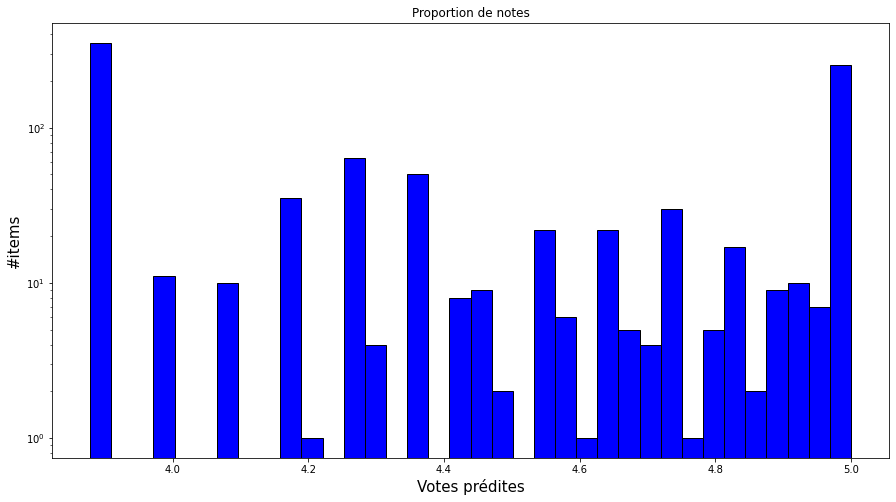

In [61]:
''' Plot la distribution des notes  '''
plt.figure(figsize=(15,8))
plt.hist(v_j_df, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)
# Add labels
plt.title('Proportion de notes')
plt.xlabel('Votes prédites',fontsize=15)
plt.ylabel('#items',fontsize=15)

# 2.d : Erreur quadratique moyenne et histogramme de distribution

In [62]:
# Calcul du vote des 10 voisins pour chaque items 
df_10_votes_all = np.zeros((N_ITEMS, N_USERS,10))
for a in range(N_ITEMS) : 
    df_10_votes_all[a,:] = build_users_items_neigh_mtx(df_10_index.iloc[a],item_item.T)
    
    
''' THIS IS THE MAIN BOTTLENECK OF THE ALGORITHM '''

In [400]:
def predict_grade(a, item_item = item_item, df_10_index = df_10_index, df_10_votes_all = df_10_votes_all) : 
    ''' Predict the grade for item a '''
    # Compute the 10 votes from the neighbors
    df_10_votes = pd.DataFrame(df_10_votes_all[a,:])    
    v_j = item_item.iloc[a].mean()
    # Normalisation factor 
    K = 1/(df_10_neighbors_sim.iloc[a].sum())
    
    v_j_i = df_10_neighbors_sim.loc[a+1]

    v_j__ = v_j + K*np.dot(df_10_votes, v_j_i.values.reshape(-1,1))
    
    # Return the grade between 1 and 5 
    v_j_df = pd.DataFrame(v_j__)
    v_j_df[v_j_df< 1 ] = 1
    v_j_df[v_j_df > 5 ] = 5
    
    return v_j_df 

    

In [407]:
def error_item_item(item_item = item_item) : 
    ''' Return the RMSE error with the item_item methode '''
    errors = []
    for item in range(N_ITEMS) : 
        prediction = predict_grade(item)
        mse = np.square(  prediction.fillna(0).values - item_item.iloc[item,:].fillna(0).values.reshape(-1,1) ).sum()
        if np.isnan(mse) : 
            mse = 0 
        errors.append(mse / N_USERS)
    erros = np.sqrt(errors )
    return errors        

In [408]:
item_errors = error_item_item()

In [409]:
# ON EST CENSÉ OBTENIR 0.93 
print('RMSE moyenne : {}'.format(np.mean(item_errors)))

RMSE moyenne : 0.862932675497986


## Question 3

In [463]:
def svd(N_COMPONENT , user_item  = user_item) : 
    ''' Reduce the dimension with the SVD algorithm '''
    U, s, V = np.linalg.svd(user_item.fillna(0).values)
    # Sigma matrix
    S = np.zeros((N_USERS,N_ITEMS))
    S[:N_USERS, :N_USERS] = np.diag(s)
    S[N_COMPONENT:, :]  = 0 
    new_user = np.dot(U, np.dot(S,V.T))
    new_user[new_user < 1] = 1 
    new_user[new_user > 1] = 5
    return new_user 
    

In [508]:
def cross_validation_svd(N, N_COMPONENT ,k = 10, item_item = item_item) :
    ''' Return the loss with cross-validation for the SVD method '''
    # Dictionnary that will store the errors 
    errors = {}
    counts = {}
    item_item_true = item_item.copy()
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = True ).values())) : 
        # Copy the original user-item matrix 
        item_item = item_item.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:2]

        def to_convert(x, item_item) :
            # Make the test rating to NaN
            try : 
                item_item.iloc[x['item.id'],x['user.id']] = np.nan
            except : 
                pass
            
        indexes_test.apply(to_convert , axis = 1 , args = [item_item])
        # Set the error to 0
        errors[i] = 0 
        
        def compute_dist(x,  errors, i, item_item , prediction_svd) :
            '''Compute the RMSE''' 
            
            item = x['item.id']
            user = x['user.id']


            try : 
                prediction = prediction_svd[item,user]
                true_value = item_item.iloc[item, user]
                error =  ( prediction - true_value)**2
                # If NaN : pass
                if np.isnan(error) : 
                    return Non
            except :
                error = 0 
                pass

            # Increment the error 
            errors[i]+=error
            return None 

        prediction_svd = svd(N_COMPONENT, item_item.T).T
        prediction_svd = np.nan_to_num(prediction_svd, 0)         
        indexes_test = indexes_test.fillna(0)
        # Apply the computation of RMSE 
        indexes_test.apply(compute_dist, axis = 1 , args = [ errors,i, item_item_true, prediction_svd ])
        # Normalise by the size of the testing set 
        errors[i]=  np.sqrt( errors[i] /    indexes_test.shape[0])
            
    return errors
    
    

In [509]:
svd_errors = cross_validation_svd(N = votes.shape[0],N_COMPONENT = 400 ,k = 5)

In [510]:
# ON EST CENSÉ OBTENIR 0.8
print('SVD RMSE with cross-validation with 5 folds : {}'.format(np.mean(list(svd_errors.values()))))

SVD RMSE with cross-validation with 5 folds : 0.9354627118685086


In [470]:
errors_component = {}
for i in range(1,N_USERS, 50) : 
    svd_e = cross_validation_svd(N = votes.shape[0],N_COMPONENT = i ,k = 5)
    errors_component[i]= np.mean(list(svd_e.values()))

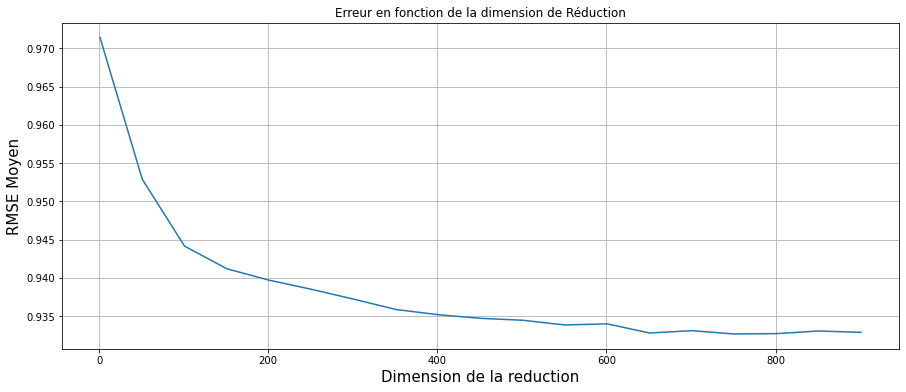

In [471]:
plt.figure(figsize=(15,6))
plt.title('Erreur en fonction de la dimension de Réduction')
plt.xlabel('Dimension de la reduction',fontsize=15)
plt.ylabel('RMSE Moyen',fontsize=15)
plt.grid(True)
plt.plot(list(errors_component.keys()),list(errors_component.values()))

## Question 4 

## 1 : Calcul de la matrice des similarites entre utilisateurs 

In [474]:
# TO DO : CHANGE THE COSINE TO BE THE CORRELATION 
def correlation(u,v) : 
    ''' Return the correlation between u and v '''
    return cosine_similarity(u,v)

In [519]:
def user_user_distance(user_item = user_item.iloc[1:], size = N_USERS) : 
    ''' Return a N_USERS x N_USERS matrix with correlation score between each user '''
    df_sim = pd.DataFrame(np.zeros((size, size)))
    for a in range(size) :
        df_sim.iloc[a] = correlation(user_item.iloc[a].fillna(0).values.reshape(1, -1), user_item.fillna(0))
    return df_sim

## 2 : Calcul des notes moyens par cluster 

In [537]:
def compute_grade_cluster(clusters , user_item = user_item ) : 
    ''' Compute the average score by item for each user with the given clusters '''
    
    # Matrix to return : the prediction with K-means
    user_pred = user_item.copy()
    
    for cluster in np.unique(clusters) : 
        index_user = np.where(clusters == cluster)[0]
        # Get the users of the cluster
        user_c = user_item.iloc[index_user]
        # Get the mean score for each item 
        mean_i = user_c.mean(axis = 0)
        user_pred.iloc[index_user, :] = mean_i
    
    return user_pred
    

## 3 : Cross-validation

In [566]:
def cross_validation_kmeans(N= votes.shape[0], n_clusters = 5 ,k = 5, user_item = user_item) :
    ''' Return the loss with cross-validation for the k-means method '''
    # Dictionnary that will store the errors 
    errors = {}
    counts = {}
    user_item_true = user_item.copy()
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = True ).values())) : 
        # Copy the original user-item matrix 
        user_item = user_item.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:2]

        def to_convert(x, user_item) :
            # Make the test rating to NaN
            try : 
                user_item.iloc[x['user.id'],x['item.id']] = np.nan
            except : 
                pass
            
        indexes_test.apply(to_convert , axis = 1 , args = [user_item])
        # Set the error to 0
        errors[i] = 0 
        
        def compute_dist(x,  errors, i, user_item ,predictions_kmeans ) :
            '''Compute the RMSE''' 
            
            item = x['item.id']
            user = x['user.id']

            try : 
                prediction = predictions_kmeans.iloc[item,user]
                true_value = user_item.iloc[user, item]
                error =  ( prediction - true_value)**2
                # If NaN : pass
                if np.isnan(error) : 
                    return Non
            except :
                error = 0 
                pass

            # Increment the error 
            errors[i]+=error
            return None 

        user_d = user_user_distance(user_item = user_item.iloc[1:])
        # Compute the centroids with K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=77).fit(user_d)
        # Get the predictions with K-means
        predictions_kmeans = compute_grade_cluster(kmeans.labels_)
        # Apply the computation of RMSE 
        indexes_test.apply(compute_dist, axis = 1 , args = [ errors,i, user_item_true, predictions_kmeans ])
        # Normalise by the size of the testing set 
        errors[i]=  np.sqrt( errors[i] /    indexes_test.shape[0])
            
    return errors
    
    

In [567]:
cross_validation_kmeans(n_clusters = 5 ,k = 5, user_item = user_item)

<ipython-input-566-808c60238c15>:48: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=77).fit(user_d)


{0: 1.247703453510962,
 1: 1.2552373566579638,
 2: 1.2567513045982943,
 3: 1.2447003187236283,
 4: 1.2416474241688675}

## 4 : Résumé des résultats 

In [568]:
def get_results_kmeans(clusters = [5,10, 20, 40, 80]) : 
    ''' Get the RMSE for different size of clusters '''
    errors = {}
    for c in clusters : 
        err = cross_validation_kmeans(n_clusters = c ,k = 5, user_item = user_item)
        errors[c] = np.mean(list(err.values()))
    return errors 

In [569]:
errors_clusters = get_results_kmeans()

<ipython-input-566-808c60238c15>:48: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=77).fit(user_d)
<ipython-input-566-808c60238c15>:48: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=77).fit(user_d)
<ipython-input-566-808c60238c15>:48: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=77).fit(user_d)
<ipython-input-566-808c60238c15>:48: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=77).fit(user_d)
<ipython-input-566-808c60238c15>:48: ConvergenceWarning: Number o

In [570]:
errors_clusters

{5: 1.249207971531943,
 10: 1.2514968297849496,
 20: 1.231400668896718,
 40: 1.1858173793288835,
 80: 1.1282058047615344}

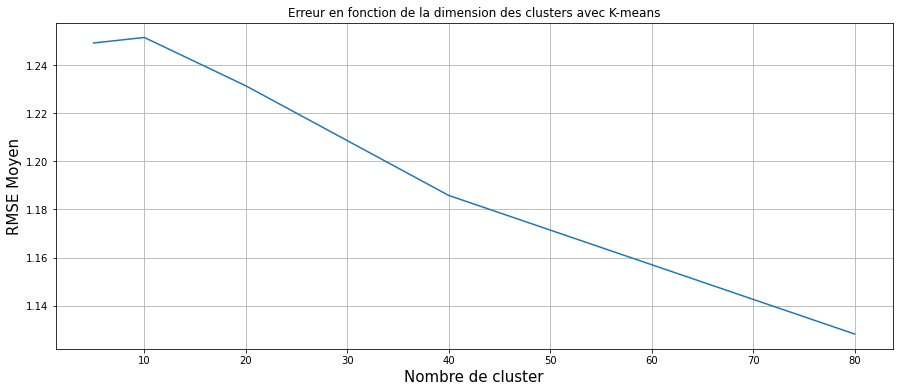

In [572]:
plt.figure(figsize=(15,6))
plt.title('Erreur en fonction de la dimension des clusters avec K-means')
plt.xlabel('Nombre de cluster',fontsize=15)
plt.ylabel('RMSE Moyen',fontsize=15)
plt.grid(True)
plt.plot(list(errors_clusters.keys()),list(errors_clusters.values()))

In [573]:
print('Best result with 80 clusters with K-means : {}'.format(errors_clusters[80]))

Best result with 80 clusters with K-means : 1.1282058047615344
